In [46]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
%matplotlib inline
import matplotlib.pyplot as plt
from random import seed # for setting seed
import tensorflow
from IPython import sys_info
import os
import gc # garbage collection
import random
import os
import shutil

2024-05-29 09:00:19.364530: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-29 09:00:20.234166: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
from tensorflow.python.client import device_lib
# print out the CPUs and GPUs
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8110504857861803704
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15242821632
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2660351311588597550
physical_device_desc: "device: 0, name: Tesla V100-PCIE-16GB, pci bus id: 0001:00:00.0, compute capability: 7.0"
xla_global_id: 416903419
]


2024-05-29 09:00:22.313516: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /device:GPU:0 with 14536 MB memory:  -> device: 0, name: Tesla V100-PCIE-16GB, pci bus id: 0001:00:00.0, compute capability: 7.0


In [3]:
from PIL import Image
Image.MAX_IMAGE_PIXELS = None

In [4]:
from tensorflow.keras.applications import ResNet50, VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Input

from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import Sequence


In [5]:
folder = 'TOP100_ARTISTS_WITH_ALL_PICTURES'

# List the files in the folder
all_pictures = os.listdir(folder)

file_path = "TOP100_ARTISTS_WITH_ALL_PICTURES.csv"
df = pd.read_csv(file_path)
print(df.head())

NUM_CLASSES = len(df['artist'].unique().tolist())

print("Number of classes:", NUM_CLASSES)


                    artist  date                 genre  pixelsx  pixelsy  \
0          Ivan Aivazovsky  1873                marina   7444.0   5811.0   
1                   Titian  1562         self-portrait   4524.0   6018.0   
2  Lucas Cranach the Elder  1534  allegorical painting   4344.0   6240.0   
3             Odilon Redon  1910     literary painting   4500.0   5738.0   
4           William Turner  1839                marina   5684.0   4226.0   

   size_bytes   source                         style  \
0   3189597.0  wikiart                   Romanticism   
1   8847626.0  wikiart  Mannerism (Late Renaissance)   
2  11276229.0  wikiart          Northern Renaissance   
3   2707505.0  wikiart                     Symbolism   
4   5103820.0  wikiart                   Romanticism   

                                               title    artist_group  \
0                                       Storm at sea  train_and_test   
1                                      Self-portrait  train_an

# Create the TEST and TRAIN sets

In [6]:
import shutil

In [7]:
# GROUP THE FILES BY EACH ARTIST
def group_files_per_artist():
  data_per_artist = {}

  # Iterate over each row of the DataFrame
  for index, row in df.iterrows():
      artist = row['artist']
      new_filename = row['new_filename']

      # Check if the artist is already in the dictionary
      if artist in data_per_artist:
          # Add the new_filename to the existing list of the artist
          data_per_artist[artist].append(new_filename)
      else:
          # Create a new list for the artist and add the new_filename
          data_per_artist[artist] = [new_filename]

  return data_per_artist

# SPLIT THE FILES INTO TRAIN AND TEST SETS (CREATE NEW DATASETS)
def split_test_train(data_per_artist, train_percentage = 0.8):

  TRAIN_names = []
  TEST_names = []

  # Iterate over each artist and their 'new_filename'
  for artist, filenames in data_per_artist.items():
      # Calculate the number of files for training and testing
      total_files = len(filenames)
      num_train = int(train_percentage * total_files)

      # Shuffle the filenames to avoid selection biases
      random.shuffle(filenames)

      # Divide the filenames into train and test
      train_filenames = filenames[:num_train]
      test_filenames = filenames[num_train:]

      # Store the divided filenames into train and test
      TRAIN_names.extend(train_filenames)
      TEST_names.extend(test_filenames)
  return TRAIN_names, TEST_names



# CREATE TEST and TRAIN folders
def create_train_test_folders(folder, TRAIN_names, TEST_names):
    # Output folder for TRAIN and TEST
    train_folder = os.path.join(folder, 'TRAIN')
    test_folder = os.path.join(folder, 'TEST')

    # Create TRAIN and TEST folders if they don't exist
    os.makedirs(train_folder, exist_ok=True)
    os.makedirs(test_folder, exist_ok=True)

    # Move images from TRAIN to TRAIN folder
    for filename in TRAIN_names:
        src = os.path.join(folder, filename)
        dst = os.path.join(train_folder, filename)
        shutil.move(src, dst)

    # Move images from TEST to TEST folder
    for filename in TEST_names:
        src = os.path.join(folder, filename)
        dst = os.path.join(test_folder, filename)
        shutil.move(src, dst)

    # Create df_train with rows whose 'new_filename' is in TRAIN_names and keep only 'artist' and 'new_filename' columns
    train_dataframe = df[df['new_filename'].isin(TRAIN_names)][['artist', 'new_filename']]
    # File path for the CSV file
    file_path = os.path.join(folder, 'train_dataframe.csv')
    # Save the DataFrame as CSV
    train_dataframe.to_csv(file_path, index=False)

    # Create df_test with rows whose 'new_filename' is in TEST_names and keep only 'artist' and 'new_filename' columns
    test_dataframe = df[df['new_filename'].isin(TEST_names)][['artist', 'new_filename']]
    # File path for the CSV file
    file_path = os.path.join(folder, 'test_dataframe.csv')
    # Save the DataFrame as CSV
    test_dataframe.to_csv(file_path, index=False)

    return train_dataframe, test_dataframe

if not (os.path.exists(os.path.join(folder, 'TRAIN')) and os.path.exists(os.path.join(folder, 'TEST'))):
  # Group files per artist
  data_per_artist = group_files_per_artist()
  # Print the number of files for each artist
  print("- Artists and numer of images:")
  for key in data_per_artist.keys():
    print(key, len(data_per_artist[key]))

  # Split data
  TRAIN_names, TEST_names = split_test_train(data_per_artist)

  # Use the function to create TRAIN and TEST folders
  train_dataframe, test_dataframe = create_train_test_folders(folder, TRAIN_names, TEST_names)
  print("\nImages successfully moved to TRAIN and TEST folders.")
else:
  print("TRAIN and TEST folders already exist. Reading train and test DataFrames from CSV files...")

  # Read train and test DataFrames from CSV files
  train_csv_path = os.path.join(folder, 'train_dataframe.csv')
  test_csv_path = os.path.join(folder, 'test_dataframe.csv')
  train_dataframe = pd.read_csv(train_csv_path)
  test_dataframe = pd.read_csv(test_csv_path)

  print("Train DataFrame:", train_dataframe.shape)
  print("Test DataFrame:", test_dataframe.shape)

TRAIN and TEST folders already exist. Reading train and test DataFrames from CSV files...
Train DataFrame: (23057, 2)
Test DataFrame: (5808, 2)


# Prepare the data

In [8]:
from torchvision import datasets, transforms

# Define the transformation to convert images to PyTorch tensors
transf = transforms.Compose([transforms.ToTensor()])

# Paths of the training and testing folders
train_folder = 'TOP100_ARTISTS_WITH_ALL_PICTURES/TRAIN'
test_folder = 'TOP100_ARTISTS_WITH_ALL_PICTURES/TEST'

# Get the file names of training and testing images from the dataframes
train_filenames = train_dataframe['new_filename'].tolist()
test_filenames = test_dataframe['new_filename'].tolist()

print(len(train_filenames))


# Create empty lists for images and labels
train_images = []
train_labels = []
test_images = []
test_labels = []

# Load training images
for filename in train_filenames:
    img_path = os.path.join(train_folder, filename)
    img = Image.open(img_path)
    img_tensor = transf(img)
    train_images.append(img_tensor)
    # Get label from the dataframe
    label = train_dataframe[train_dataframe['new_filename'] == filename]['artist'].iloc[0]
    train_labels.append(label)
# Load testing images
for filename in test_filenames:
    img_path = os.path.join(test_folder, filename)
    img = Image.open(img_path)
    img_tensor = transf(img)
    test_images.append(img_tensor)
    # Get label from the dataframe
    label = test_dataframe[test_dataframe['new_filename'] == filename]['artist'].iloc[0]
    test_labels.append(label)


23057


In [9]:
import torch

# Create a dictionary to map artist names to unique numerical values
artist_to_index = {artist: i for i, artist in enumerate(train_dataframe['artist'].unique())}

# Convert string labels to integers using the dictionary
train_labels = [artist_to_index[artist] for artist in train_labels]
test_labels = [artist_to_index[artist] for artist in test_labels]

# Create PyTorch tensors for training and testing images and labels
train_dataset = torch.utils.data.TensorDataset(torch.stack(train_images), torch.tensor(train_labels))
all_test_dataset = torch.utils.data.TensorDataset(torch.stack(test_images), torch.tensor(test_labels))


In [10]:
print(f'Shape of training set: {train_dataset.tensors[0].shape}')
print(f'Shape of test set: {all_test_dataset.tensors[0].shape}')
print(f'Shape of training labels: {train_dataset.tensors[1].shape}')
print(f'Shape of test labels: {all_test_dataset.tensors[1].shape}')

Shape of training set: torch.Size([23057, 3, 224, 224])
Shape of test set: torch.Size([5808, 3, 224, 224])
Shape of training labels: torch.Size([23057])
Shape of test labels: torch.Size([5808])


In [11]:
import collections

# Get the labels from the training and test datasets
y_train = train_dataset.tensors[1].tolist()
y_test = all_test_dataset.tensors[1].tolist()

# Count the number of images per category in the training data
counter_train = collections.Counter(y_train)
print('Class Image Counter for Training Data:')
print(counter_train)

# Count the number of images per category in the test data
counter_test = collections.Counter(y_test)
print('\nClass Image Counter for Test Data:')
print(counter_test)


Class Image Counter for Training Data:
Counter({89: 395, 95: 394, 44: 388, 42: 384, 83: 384, 15: 383, 41: 380, 75: 380, 14: 377, 61: 372, 69: 372, 66: 368, 74: 363, 35: 361, 50: 359, 25: 354, 0: 353, 34: 351, 70: 349, 18: 346, 19: 344, 47: 325, 40: 320, 87: 320, 73: 300, 80: 300, 32: 285, 79: 282, 3: 280, 59: 262, 82: 258, 38: 257, 20: 256, 54: 256, 52: 249, 13: 243, 60: 242, 72: 241, 17: 240, 91: 232, 62: 230, 65: 227, 37: 226, 21: 220, 93: 217, 99: 212, 98: 207, 92: 203, 4: 192, 36: 192, 76: 192, 45: 191, 10: 190, 55: 188, 58: 188, 43: 187, 64: 184, 56: 183, 78: 183, 6: 181, 29: 180, 31: 180, 94: 180, 51: 176, 63: 176, 86: 176, 57: 171, 81: 171, 49: 168, 8: 167, 90: 164, 16: 163, 26: 162, 1: 161, 48: 161, 71: 160, 5: 156, 39: 156, 23: 154, 68: 153, 22: 152, 67: 152, 24: 148, 88: 148, 7: 144, 11: 144, 85: 144, 77: 143, 97: 143, 30: 141, 84: 141, 46: 140, 2: 138, 9: 138, 33: 137, 53: 136, 28: 135, 96: 134, 12: 133, 27: 133})

Class Image Counter for Test Data:
Counter({95: 99, 89: 99, 

In [12]:
from sklearn.model_selection import StratifiedShuffleSplit

# Get the labels from the test dataset
y_test = all_test_dataset.tensors[1].tolist()

# Use StratifiedShuffleSplit to split the data into validation set and test set
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)

# Make a list of indices for the test set
indices_test = list(range(len(all_test_dataset)))

# Execute the stratified split
for idx_test, idx_val in split.split(indices_test, y_test):
    print("Test Indices:", idx_test)
    print("Validation Indices:", idx_val)
    print("Number of samples in validation set:", len(idx_val))
    print("Number of samples in test set:", len(idx_test))


Test Indices: [3961 2327 2139 ... 1698  872 1051]
Validation Indices: [5005  469  755 ... 3330 3397 3990]
Number of samples in validation set: 1162
Number of samples in test set: 4646


# Create two datasets from all_test_dataset

In [13]:
from torch.utils.data import Subset

# Use torch utility to make subsets for all_test_dataset

val_dataset = Subset(all_test_dataset, idx_val)  # List of indices for validation split
test_dataset = Subset(all_test_dataset, idx_test)  # List of indices for test split


In [14]:
# Get the labels from the validation and test datasets and convert them to integers
y_val = [int(all_test_dataset[idx][1]) for idx in idx_val]
y_test = [int(all_test_dataset[idx][1]) for idx in idx_test]

# Count the number of images per category in the validation data
counter_val = collections.Counter(y_val)
print('Class Image Counter for Validation Data:')
print(counter_val)

# Count the number of images per category in the test data
counter_test = collections.Counter(y_test)
print('\nClass Image Counter for Test Data:')
print(counter_test)


Class Image Counter for Validation Data:
Counter({95: 20, 44: 20, 89: 20, 83: 20, 14: 19, 75: 19, 69: 19, 15: 19, 61: 19, 42: 19, 41: 19, 66: 19, 70: 18, 50: 18, 35: 18, 74: 18, 34: 18, 25: 18, 0: 18, 19: 17, 18: 17, 47: 16, 40: 16, 87: 16, 73: 15, 80: 15, 3: 14, 32: 14, 79: 14, 38: 13, 54: 13, 59: 13, 82: 13, 20: 13, 52: 13, 13: 12, 72: 12, 91: 12, 62: 12, 17: 12, 60: 12, 93: 11, 65: 11, 99: 11, 21: 11, 37: 11, 4: 10, 36: 10, 10: 10, 76: 10, 92: 10, 58: 10, 98: 10, 45: 10, 31: 9, 63: 9, 78: 9, 51: 9, 55: 9, 56: 9, 49: 9, 43: 9, 57: 9, 81: 9, 29: 9, 6: 9, 94: 9, 86: 9, 64: 9, 1: 8, 8: 8, 23: 8, 16: 8, 71: 8, 90: 8, 22: 8, 26: 8, 67: 8, 39: 8, 5: 8, 68: 8, 48: 8, 28: 7, 96: 7, 7: 7, 53: 7, 24: 7, 77: 7, 85: 7, 12: 7, 11: 7, 27: 7, 2: 7, 46: 7, 9: 7, 33: 7, 88: 7, 84: 7, 30: 7, 97: 7})

Class Image Counter for Test Data:
Counter({95: 79, 89: 79, 44: 78, 83: 77, 15: 77, 42: 77, 75: 76, 14: 76, 41: 76, 69: 74, 61: 74, 66: 73, 35: 73, 74: 73, 50: 72, 25: 71, 0: 71, 70: 70, 18: 70, 34: 70, 1

In [15]:
import torchvision.utils as utils

def plot_img(img, title=None):
    npimg = img.numpy()
    npimg_T = np.transpose(npimg, (1, 2, 0))
    plt.imshow(npimg_T)
    if title:
        plt.title(title)
    plt.axis('on')
    plt.show()

# Function to visualize samples from a data tensor
def plot_tensor(tensor, random_id=False, class_id=None):
    if random_id:
        rnd_inds = np.random.randint(0, len(tensor), 100)
        X_show = [tensor[i][0] for i in rnd_inds]
    else:
        if class_id is None:
            X_show = []
            for j in range(NUM_CLASSES):  # NUM_CLASSES classes
                ii = -1
                for i in range(len(tensor)):
                    if tensor[i][1] == j:
                        ii += 1
                        if ii > 19:
                            break
                        else:
                            X_show.append(tensor[i][0])
        else:
            print(f'Showing samples from {len(tensor)} tensors:')
            X_show = []
            ii = -1
            for i in range(len(tensor)):
                if tensor[i][1] == class_id:
                    ii += 1
                    if ii > 19:
                        break
                    else:
                        X_show.append(tensor[i][0])

    X_grid = utils.make_grid(X_show, nrow=20, padding=1)
    plot_img(X_grid, title='Image samples from each class')


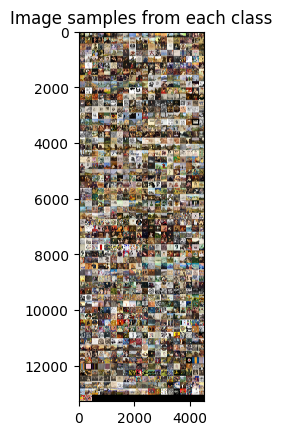

In [16]:
plot_tensor(val_dataset)

Showing samples from 1162 tensors:


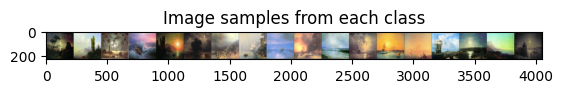

In [17]:
plot_tensor(val_dataset,class_id=0)

Showing samples from 1162 tensors:


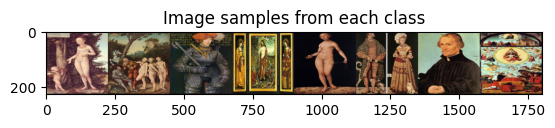

In [18]:
plot_tensor(val_dataset,class_id=1)

Showing samples from 1162 tensors:


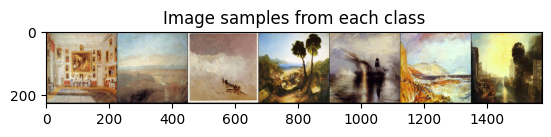

In [19]:
plot_tensor(val_dataset,class_id=2)

Showing samples from 1162 tensors:


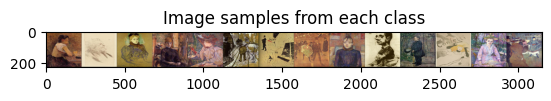

In [20]:
plot_tensor(val_dataset,class_id=3)

Showing samples from 1162 tensors:


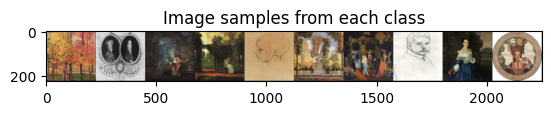

In [21]:
plot_tensor(val_dataset,class_id=4)

In [22]:
def get_meanstd(data):
    # List of lists of mean values for each image
    meanRGB = [np.mean(x.numpy(), axis=(1,2)) for x, _ in data]
    stdRGB = [np.std(x.numpy(), axis=(1,2)) for x, _ in data]
    print('Mean & std values for sample:')
    print(meanRGB[0])
    print(stdRGB[0])

    # Calculate the global mean of the dataset from these means
    meanR = np.mean([m[0] for m in meanRGB])
    meanG = np.mean([m[1] for m in meanRGB])
    meanB = np.mean([m[2] for m in meanRGB])

    # Calculate the global standard deviation of the dataset
    stdR = np.mean([s[0] for s in stdRGB])
    stdG = np.mean([s[1] for s in stdRGB])
    stdB = np.mean([s[2] for s in stdRGB])

    print('\nMean value for dataset:')
    print(f'Mean Values: {meanR} {meanG} {meanB}')
    print(f'STD Values: {stdR} {stdG} {stdB}')

    return [meanR, meanG, meanB], [stdR, stdG, stdB]

means, stds = get_meanstd(train_dataset)


Mean & std values for sample:
[0.43174443 0.46031097 0.45549223]
[0.12931994 0.12496761 0.10158332]

Mean value for dataset:
Mean Values: 0.5193091034889221 0.46988964080810547 0.40727314352989197
STD Values: 0.21091754734516144 0.20046430826187134 0.18958204984664917


# Define the image transformations (for train_ds & test_all)

Showing samples from 23057 tensors:


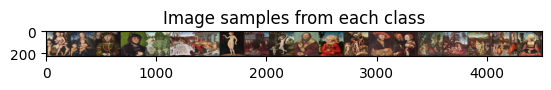

In [23]:
# Transformations for training set
train_transformer = transforms.Compose([transforms.RandomHorizontalFlip(p=0.5),
                                        transforms.RandomVerticalFlip(p=0.5),
                                        transforms.ToTensor(),
                                        transforms.Normalize([means[0], means[1], means[2]],
                                                             [stds[0], stds[1], stds[2]])])

# Standard transformations for test set
test0_transformer = transforms.Compose([transforms.ToTensor(),
                                        transforms.Normalize([means[0], means[1], means[2]],
                                                             [stds[0], stds[1], stds[2]])])

''' Update the transform functions for train_ds & test_all '''
train_dataset.transform = train_transformer
test_dataset.transform = test0_transformer

plot_tensor(train_dataset, class_id=1)  # Can plot the converted data after transformation


# Create dataloaders from train_ds & val_ds

In [24]:
from torch.utils.data import DataLoader



# Create Data Loaders (training)
train_dl = DataLoader(train_dataset,
                      batch_size=32,
                      shuffle=True)

# Create Data Loader (validation)
val_dl = DataLoader(val_dataset,
                    batch_size=64,
                    shuffle=False)

# And get a batch of data from train_dl
for x,y in train_dl:
    print(x.shape)
    print(y.shape)
    break

# Extract a batch of data from val_dl
for x,y in val_dl:
    print(x.shape)
    print(y.shape)
    break

torch.Size([32, 3, 224, 224])
torch.Size([32])
torch.Size([64, 3, 224, 224])
torch.Size([64])


# Defining a Loss Function

In [25]:
import torch.nn as nn


loss_func = nn.CrossEntropyLoss(reduction='sum')

In [26]:
# get the current learning rate helper function
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']

In [27]:
def plot_out(loss_hist,metric_hist,epochs=None):

    # Train-Validation Progress
    fig = make_subplots(rows=1, cols=2,subplot_titles=['lost_hist','metric_hist'])

    # Plot Model Learning Rate
    fig.add_trace(go.Scatter(x=[*range(1,epochs+1)],
                             y=loss_hist["train"],
                             name='loss_hist["train"]',
                             line=dict(color="#0000ff")),row=1, col=1)
    fig.add_trace(go.Scatter(x=[*range(1,epochs+1)],
                             y=loss_hist["val"],
                             name='loss_hist["val"]'),row=1, col=1)

    # Plot Metric
    fig.add_trace(go.Scatter(x=[*range(1,epochs+1)],
                             y=metric_hist["train"],
                             name='metric_hist["train"]'),row=1, col=2)
    fig.add_trace(go.Scatter(x=[*range(1,epochs+1)],
                             y=metric_hist["val"],
                             name='metric_hist["val"]'),row=1, col=2)

    fig.update_layout(template='plotly_white')
    fig.update_layout(margin={"r":0,"t":60,"l":0,"b":0},height=300)
    fig.show()


# Training and Tranfer Learning

In [28]:
import copy


''' Helper function to count the number of correct predictions '''
def metrics_batch(output, target):
    # get output class
    pred = output.argmax(dim=1, keepdim=True)

    # compare output class with target class
    corrects=pred.eq(target.view_as(pred)).sum().item()
    return corrects

''' Helper function to compute the loss value per batch of data '''
def loss_batch(loss_func, output, target, opt=None):

    # get loss
    loss = loss_func(output, target)

    # get performance metric
    metric_b = metrics_batch(output,target)

    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()

    return loss.item(), metric_b

# define computation hardware approach (GPU/CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Compute the Loss Value & Performance Metric

def loss_epoch(model,loss_func,dataset_dl,check_id=False,opt=None):

    # initialising variables
    running_loss=0.0
    running_metric=0.0
    len_data=len(dataset_dl.dataset)

    # internal loop
    for xb, yb in dataset_dl:

        xb=xb.to(device) # move X of batch to device
        yb=yb.to(device) # move y of batch to device

        output=model(xb) # get model output
        loss_b,metric_b=loss_batch(loss_func, output, yb, opt) # get loss per batch
        running_loss+=loss_b # update running loss

        if(metric_b is not None):
            running_metric+=metric_b # update running metric
        if(check_id):
            break # stop if only checking

    loss=running_loss/float(len_data) # average loss value
    metric=running_metric/float(len_data) # average metric value

    return loss, metric

In [29]:
''' TRAINING FUNCTION '''
# model - input model
# parameters - input parameter dictionary

def train_val(model, params, verbose = False):

    # extract model parameters
    epochs=params["epochs"]
    loss_func=params["loss_func"]
    opt=params["optimiser"]
    train_dl=params["train_dl"]
    val_dl=params["val_dl"]
    check_id=params["check_id"]
    lr_scheduler=params["lr_scheduler"]
    path=params["path"]

    loss_history={"train": [],"val": []} # history of loss values in each epoch
    metric_history={"train": [],"val": []} # histroy of metric values in each epoch
    best_model_wts = copy.deepcopy(model.state_dict()) # copy weights for best model
    best_loss=float('inf') # initialize best loss to a large value

    # main loop
    for epoch in range(epochs):

        current_lr=get_lr(opt) # get current learning rate
        if(verbose):
            print(f"Epoch {epoch}/{epochs-1}, current lr={current_lr}")

        # train model on training dataset
        model.train()
        train_loss, train_metric=loss_epoch(model,loss_func,train_dl,check_id,opt)

        # collect loss and metric for training dataset
        loss_history["train"].append(train_loss)
        metric_history["train"].append(train_metric)

        # evaluate model on validation dataset
        model.eval()
        with torch.no_grad():
            val_loss, val_metric=loss_epoch(model,loss_func,val_dl,check_id)


        # store best model
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())

            # store weights into a local file
            torch.save(model.state_dict(), path)
            if(verbose):
                print("Copied best model weights!")

        # collect loss and metric for validation dataset
        loss_history["val"].append(val_loss)
        metric_history["val"].append(val_metric)

        # learning rate schedule
        lr_scheduler.step(val_loss)

        if(verbose):
            print(f"train loss: {train_loss:.6f}, dev loss: {val_loss:.6f}, accuracy: {100*val_metric:.2f}")
            print('')

    # load best model weights
    model.load_state_dict(best_model_wts)

    return model, loss_history, metric_history

In [30]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

def plot_out(loss_hist, metric_hist, epochs=None):
    # Crear la figura y los ejes
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # Gráfico de historial de pérdidas
    axs[0].plot(range(1, epochs+1), loss_hist["train"], label="Train loss")
    axs[0].plot(range(1, epochs+1), loss_hist["val"], label="Validation loss")
    axs[0].set_title('loss_hist')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].legend()

    # Gráfico de historial de métricas
    axs[1].plot(range(1, epochs+1), metric_hist["train"], label="Train acc")
    axs[1].plot(range(1, epochs+1), metric_hist["val"], label="Validation acc")
    axs[1].set_title('acc_hist')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()

    # Ajustar el espaciado entre los subplots
    plt.tight_layout()

    # Mostrar el gráfico
    plt.show()


In [31]:
import torch
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR, ReduceLROnPlateau
import torchvision.transforms as transforms

# Load the pretrained DenseNet201 model
pre_densenet201 = models.densenet169(pretrained=True)

# Congelar todas las capas
for param in pre_densenet201.parameters():
    param.requires_grad = False

# Descongelar más capas para mejorar la capacidad de ajuste
#for param in pre_densenet201.features.denseblock4.parameters():
#    param.requires_grad = True

# Añadir Dropout a la capa totalmente conectada
num_ftrs = pre_densenet201.classifier.in_features
pre_densenet201.classifier = nn.Sequential(
    nn.BatchNorm1d(num_ftrs),
    nn.Dropout(0.5),
    nn.Linear(num_ftrs, NUM_CLASSES)
)

for param in pre_densenet201.classifier.parameters():
    param.requires_grad = True

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
pre_densenet201.to(device)

#Augmenting the data
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        transforms.RandomRotation(20),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.8, 1.2), shear=10),
        transforms.RandomVerticalFlip(),
        transforms.RandomGrayscale(p=0.1),
        transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
        transforms.ToTensor(),
        transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3)),
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]),
}

# Assume train_dl and val_dl are already defined
# Apply data_transforms to the datasets
train_dl.dataset.transform = data_transforms['train']
val_dl.dataset.transform = data_transforms['val']


# Loss function
loss_func = nn.CrossEntropyLoss(reduction="sum")

# Define an optimiser with weight decay
optimiser = optim.Adagrad(filter(lambda p: p.requires_grad, pre_densenet201.parameters()), lr=1e-2, weight_decay=1e-2)

# Define learning rate scheduler
lr_scheduler = ReduceLROnPlateau(optimiser, mode='min', factor=0.9, patience=3, threshold=0.1, cooldown=0, min_lr=0, eps=1e-08, verbose=False)

# Set Training Parameters
params_train = {
    "epochs": 30,
    "optimiser": optimiser,
    "loss_func": loss_func,
    "train_dl": train_dl,
    "val_dl": val_dl,
    "check_id": False,
    "lr_scheduler": lr_scheduler,
    "path": "pre_densenet201.pt",
}

# Train and validate the model
pre_densenet201, loss_hist, metric_hist = train_val(pre_densenet201, params_train, verbose=True)


Epoch 0/29, current lr=0.01


/anaconda/envs/azureml_py38/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Copied best model weights!
train loss: 2.575176, dev loss: 1.877643, accuracy: 54.13

Epoch 1/29, current lr=0.01
Copied best model weights!
train loss: 1.885419, dev loss: 1.720021, accuracy: 58.09

Epoch 2/29, current lr=0.01
Copied best model weights!
train loss: 1.720305, dev loss: 1.658250, accuracy: 58.18

Epoch 3/29, current lr=0.01
Copied best model weights!
train loss: 1.629978, dev loss: 1.612985, accuracy: 58.86

Epoch 4/29, current lr=0.01
Copied best model weights!
train loss: 1.579799, dev loss: 1.581393, accuracy: 59.38

Epoch 5/29, current lr=0.01
Copied best model weights!
train loss: 1.522637, dev loss: 1.551549, accuracy: 60.07

Epoch 6/29, current lr=0.01
Copied best model weights!
train loss: 1.489319, dev loss: 1.537684, accuracy: 60.76

Epoch 7/29, current lr=0.009000000000000001
Copied best model weights!
train loss: 1.463778, dev loss: 1.519492, accuracy: 61.27

Epoch 8/29, current lr=0.009000000000000001
Copied best model weights!
train loss: 1.435474, dev los

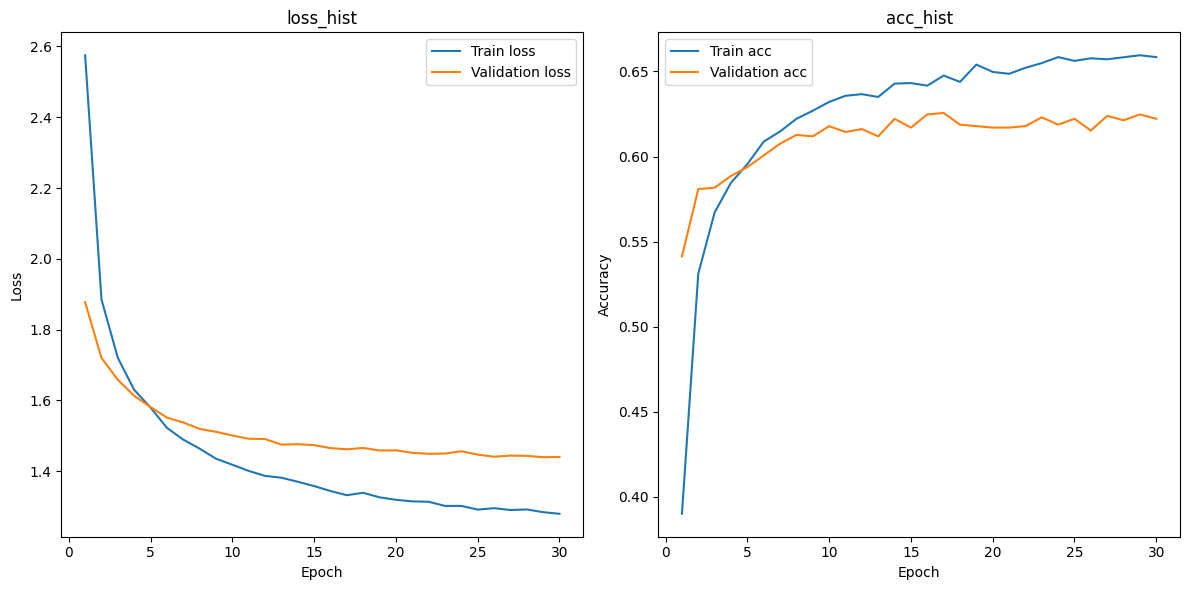

In [32]:
# Plot History
plot_out(loss_hist,metric_hist,epochs=params_train["epochs"])

In [36]:
import torch
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR, ReduceLROnPlateau
import torchvision.transforms as transforms

# Load the pretrained DenseNet201 model
pre_densenet201 = models.densenet169(pretrained=True)

# Congelar todas las capas
for param in pre_densenet201.parameters():
    param.requires_grad = False

# Descongelar más capas para mejorar la capacidad de ajuste
for param in pre_densenet201.features.denseblock4.parameters():
    param.requires_grad = True


# Añadir Dropout a la capa totalmente conectada
num_ftrs = pre_densenet201.classifier.in_features
pre_densenet201.classifier = nn.Sequential(
    nn.BatchNorm1d(num_ftrs),
    nn.Dropout(0.5),
    nn.Linear(num_ftrs, NUM_CLASSES)
)

for param in pre_densenet201.classifier.parameters():
    param.requires_grad = True

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
pre_densenet201.to(device)

#Augmenting the data
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        transforms.RandomRotation(20),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.8, 1.2), shear=10),
        transforms.RandomVerticalFlip(),
        transforms.RandomGrayscale(p=0.1),
        transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
        transforms.ToTensor(),
        transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3)),
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]),
}

# Assume train_dl and val_dl are already defined
# Apply data_transforms to the datasets
train_dl.dataset.transform = data_transforms['train']
val_dl.dataset.transform = data_transforms['val']


# Loss function
loss_func = nn.CrossEntropyLoss(reduction="sum")

# Define an optimiser with weight decay
optimiser = optim.Adagrad(filter(lambda p: p.requires_grad, pre_densenet201.parameters()), lr=1e-2, weight_decay=1e-2)

# Define learning rate scheduler
lr_scheduler = ReduceLROnPlateau(optimiser, mode='min', factor=0.9, patience=3, threshold=0.1, cooldown=0, min_lr=0, eps=1e-08, verbose=False)

# Set Training Parameters
params_train = {
    "epochs": 30,
    "optimiser": optimiser,
    "loss_func": loss_func,
    "train_dl": train_dl,
    "val_dl": val_dl,
    "check_id": False,
    "lr_scheduler": lr_scheduler,
    "path": "pre_densenet201.pt",
}

# Train and validate the model
pre_densenet201, loss_hist, metric_hist = train_val(pre_densenet201, params_train, verbose=True)

Epoch 0/29, current lr=0.01


Copied best model weights!
train loss: 2.177419, dev loss: 1.395072, accuracy: 63.25

Epoch 1/29, current lr=0.01
Copied best model weights!
train loss: 1.198467, dev loss: 1.179709, accuracy: 67.81

Epoch 2/29, current lr=0.01
Copied best model weights!
train loss: 0.788662, dev loss: 1.086873, accuracy: 69.97

Epoch 3/29, current lr=0.01
Copied best model weights!
train loss: 0.492923, dev loss: 1.037627, accuracy: 70.91

Epoch 4/29, current lr=0.01
Copied best model weights!
train loss: 0.285257, dev loss: 1.002096, accuracy: 72.89

Epoch 5/29, current lr=0.01
train loss: 0.160025, dev loss: 1.038262, accuracy: 72.55

Epoch 6/29, current lr=0.01
train loss: 0.092599, dev loss: 1.016244, accuracy: 73.24

Epoch 7/29, current lr=0.01
train loss: 0.061076, dev loss: 1.017923, accuracy: 73.32

Epoch 8/29, current lr=0.009000000000000001
train loss: 0.043074, dev loss: 1.014624, accuracy: 74.27

Epoch 9/29, current lr=0.009000000000000001
train loss: 0.032737, dev loss: 1.020191, accuracy

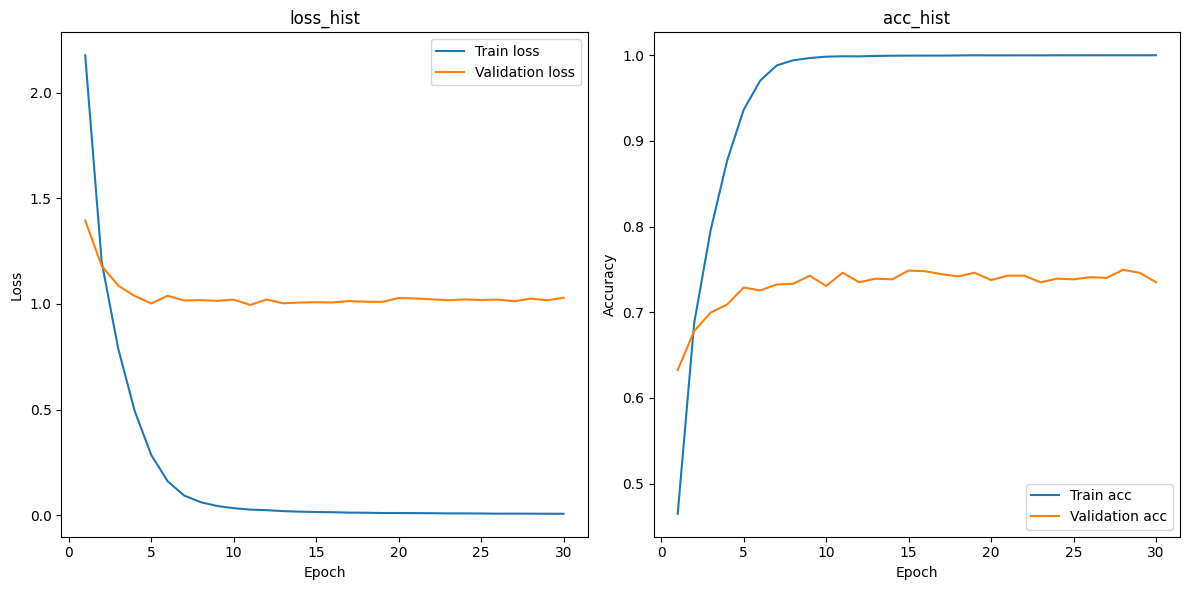

In [37]:
# Plot History
plot_out(loss_hist,metric_hist,epochs=params_train["epochs"])